In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd

# Load the dataset
data = pd.read_csv('/content/drive/MyDrive/collab/data.csv')

# Cek data awal
print("Data Awal:")
print(data.head())

# 1. Menghapus duplikasi
data = data.drop_duplicates()

# 2. Mengatasi nilai yang hilang
# Mengisi kolom 'averageRating' dan 'numVotes' dengan nilai rata-rata, jika ada nilai kosong
data['averageRating'].fillna(data['averageRating'].mean(), inplace=True)
data['numVotes'].fillna(data['numVotes'].mean(), inplace=True)

# Menghapus baris dengan 'id', 'title', 'type', atau 'genres' yang kosong
data = data.dropna(subset=['id', 'title', 'type', 'genres'])

# 3. Mengubah tipe data yang sesuai
data['averageRating'] = data['averageRating'].astype(float)
data['numVotes'] = data['numVotes'].astype(int)
data['releaseYear'] = data['releaseYear'].astype(str)  # Bisa juga menjadi integer, tergantung formatnya

# 4. Memastikan kolom 'genres' tidak mengandung nilai kosong
data['genres'] = data['genres'].str.strip().replace('', 'Unknown')

# 5. Menghapus baris dengan rating lebih dari 10 atau lebih kecil dari 0 (jika ada)
data = data[(data['averageRating'] >= 0) & (data['averageRating'] <= 10)]

# 6. Menghapus data dengan jumlah votes yang sangat rendah atau sangat tinggi (outliers)
data = data[(data['numVotes'] > 0) & (data['numVotes'] < 1000000)]

# Cek hasil setelah cleaning
print("\nData Setelah Cleaning:")
print(data.head())

# Menyimpan hasil yang telah dibersihkan
data.to_csv('data_cleaned.csv', index=False)


Data Awal:
          id                          title   type  \
0  tt0000009                     Miss Jerry  movie   
1  tt0000147  The Corbett-Fitzsimmons Fight  movie   
2  tt0000502                       Bohemios  movie   
3  tt0000574    The Story of the Kelly Gang  movie   
4  tt0000591               The Prodigal Son  movie   

                         genres  averageRating  numVotes  releaseYear  
0                       Romance            5.4     215.0       1894.0  
1      Documentary, News, Sport            5.2     539.0       1897.0  
2                           NaN            4.4      18.0       1905.0  
3  Action, Adventure, Biography            6.0     941.0       1906.0  
4                         Drama            5.7      28.0       1907.0  


<ipython-input-3-9ad6a8634497>:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['averageRating'].fillna(data['averageRating'].mean(), inplace=True)
<ipython-input-3-9ad6a8634497>:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, 


Data Setelah Cleaning:
          id                          title   type  \
0  tt0000009                     Miss Jerry  movie   
1  tt0000147  The Corbett-Fitzsimmons Fight  movie   
3  tt0000574    The Story of the Kelly Gang  movie   
4  tt0000591               The Prodigal Son  movie   
5  tt0000615             Robbery Under Arms  movie   

                         genres  averageRating  numVotes releaseYear  
0                       Romance            5.4       215      1894.0  
1      Documentary, News, Sport            5.2       539      1897.0  
3  Action, Adventure, Biography            6.0       941      1906.0  
4                         Drama            5.7        28      1907.0  
5                         Drama            4.3        27      1907.0  


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

# Fungsi untuk encoding fitur kategorikal
def encode_features(df, categorical_columns, ohe=None, le_dict=None):
    df = df.copy()  # Membuat salinan DataFrame untuk mencegah perubahan data asli
    if le_dict is None:
        le_dict = {}  # Dictionary untuk menyimpan LabelEncoder per kolom

    # Iterasi pada setiap kolom kategorikal
    for col in categorical_columns:
        if col not in df.columns:  # Lewati jika kolom tidak ada
            continue
        if col == 'genres':
            # Urutkan genre agar konsisten (bila ada beberapa genre dipisahkan koma)
            df[col] = df[col].fillna('').apply(lambda x: ','.join(sorted(x.split(','))))
        else:
            df[col] = df[col].fillna('Unknown')  # Isi nilai NaN dengan "Unknown"

        # Jika LabelEncoder untuk kolom belum dibuat, buat dan fit encoder
        if le_dict.get(col) is None:
            le_dict[col] = LabelEncoder()
            df[col] = le_dict[col].fit_transform(df[col])
        else:
            df[col] = le_dict[col].transform(df[col])  # Transformasi menggunakan encoder yang sudah ada

    # OneHotEncoding pada kolom yang telah di-label encode
    if ohe is None:
        ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
        ohe_encoded = ohe.fit_transform(df[categorical_columns])  # Fit dan transform
    else:
        ohe_encoded = ohe.transform(df[categorical_columns])  # Transformasi saja

    # Konversi hasil encoding ke DataFrame dengan nama kolom baru
    ohe_columns = ohe.get_feature_names_out(categorical_columns)
    ohe_df = pd.DataFrame(ohe_encoded, columns=ohe_columns, index=df.index)

    # Hapus kolom kategorikal asli dan gabungkan dengan hasil OneHotEncoding
    df = df.drop(columns=categorical_columns)
    df = pd.concat([df, ohe_df], axis=1)

    return df, ohe, le_dict

# Baca dataset
df = pd.read_csv('/content/data_cleaned.csv')

# Pisahkan fitur dan target
X = df.drop(['id', 'title', 'averageRating'], axis=1)  # Hapus kolom yang tidak relevan untuk prediksi
y = df['averageRating']  # Kolom target

# Identifikasi kolom kategorikal
categorical_columns = ['type', 'genres']

# Encoding fitur kategorikal
X_encoded, ohe, le_dict = encode_features(X, categorical_columns)

# Split dataset menjadi data training dan testing
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Inisialisasi Random Forest dengan parameter tertentu untuk mengontrol kompleksitas model
model = RandomForestRegressor(
    n_estimators=20,  # Kurangi jumlah pohon untuk mempercepat pelatihan
    max_depth=10,     # Batasi kedalaman maksimum pohon
    min_samples_split=5,  # Minimum jumlah sampel untuk membagi simpul
    min_samples_leaf=2,   # Minimum jumlah sampel pada setiap daun
    n_jobs=-1,  # Gunakan semua inti CPU
    random_state=42
)

# Latih model dengan data training
model.fit(X_train, y_train)

# Data testing dalam bentuk dictionary (contoh prediksi)
data_testing = {
    'type': ['movie'],  # Jenis konten
    'genres': ['Action, Adventure, Sci-Fi'],  # Genre konten
    'numVotes': [50000],  # Jumlah vote
    'releaseYear': [2023]  # Tahun rilis
}

# Ubah data testing menjadi DataFrame
data_testing = pd.DataFrame(data_testing)

# Encoding data testing menggunakan OneHotEncoder dan LabelEncoder yang telah difit
data_testing, _, _ = encode_features(data_testing, categorical_columns, ohe=ohe, le_dict=le_dict)

# Pastikan data testing memiliki kolom yang sama dengan data training
missing_cols = set(X_train.columns) - set(data_testing.columns)
for col in missing_cols:
    data_testing[col] = 0  # Tambahkan kolom yang hilang dengan nilai nol

# Hapus kolom tambahan yang tidak ada di data training
extra_cols = set(data_testing.columns) - set(X_train.columns)
data_testing = data_testing.drop(columns=list(extra_cols))

# Urutkan kolom sesuai dengan data training
data_testing = data_testing[X_train.columns]

In [ ]:
# Prediksi rating
predicted_rating = model.predict(data_testing)
print(predicted_rating)


[6.35048378]


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Membuat prediksi
y_pred = model.predict(X_test)

# Evaluasi model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Metrik Evaluasi untuk Model Regresi Random Forest:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R2) Score: {r2:.4f}")

# Menampilkan beberapa prediksi dan nilai sebenarnya
print("\nPerbandingan beberapa prediksi dengan nilai sebenarnya:")
for i in range(10):  # Menampilkan 10 prediksi pertama
    print(f"Prediksi: {y_pred[i]:.4f}, Nilai Sebenarnya: {y_test.iloc[i]:.4f}")

# Menampilkan feature importance
feature_importance = model.feature_importances_
feature_names = X_test.columns

# Mengurutkan feature importance
feature_importance_sorted = sorted(zip(feature_importance, feature_names), reverse=True)

print("\nFeature Importance:")
for importance, name in feature_importance_sorted[:10]:  # Menampilkan 10 fitur teratas
    print(f"{name}: {importance:.4f}")

Metrik Evaluasi untuk Model Regresi Random Forest:
Mean Squared Error (MSE): 0.7362
Root Mean Squared Error (RMSE): 0.8580
Mean Absolute Error (MAE): 0.4453
R-squared (R2) Score: 0.2082

Perbandingan beberapa prediksi dengan nilai sebenarnya:
Prediksi: 6.6099, Nilai Sebenarnya: 6.5000
Prediksi: 6.3629, Nilai Sebenarnya: 6.3629
Prediksi: 7.0003, Nilai Sebenarnya: 7.5000
Prediksi: 7.0564, Nilai Sebenarnya: 7.8000
Prediksi: 6.3629, Nilai Sebenarnya: 6.3629
Prediksi: 6.3629, Nilai Sebenarnya: 6.3629
Prediksi: 6.3629, Nilai Sebenarnya: 6.3629
Prediksi: 6.4113, Nilai Sebenarnya: 6.1000
Prediksi: 6.3629, Nilai Sebenarnya: 6.3629
Prediksi: 6.8655, Nilai Sebenarnya: 6.6000

Feature Importance:
numVotes: 0.4516
releaseYear: 0.1511
genres_2041: 0.1121
type_0: 0.0995
genres_2047: 0.0729
genres_2042: 0.0308
genres_1280: 0.0188
genres_1970: 0.0167
genres_2039: 0.0089
genres_2035: 0.0060


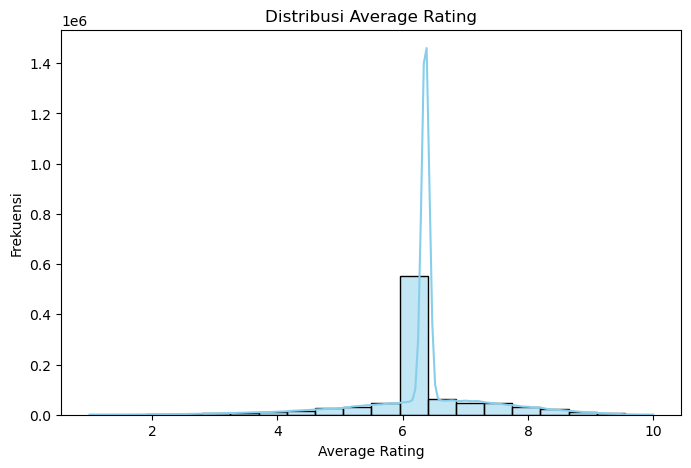

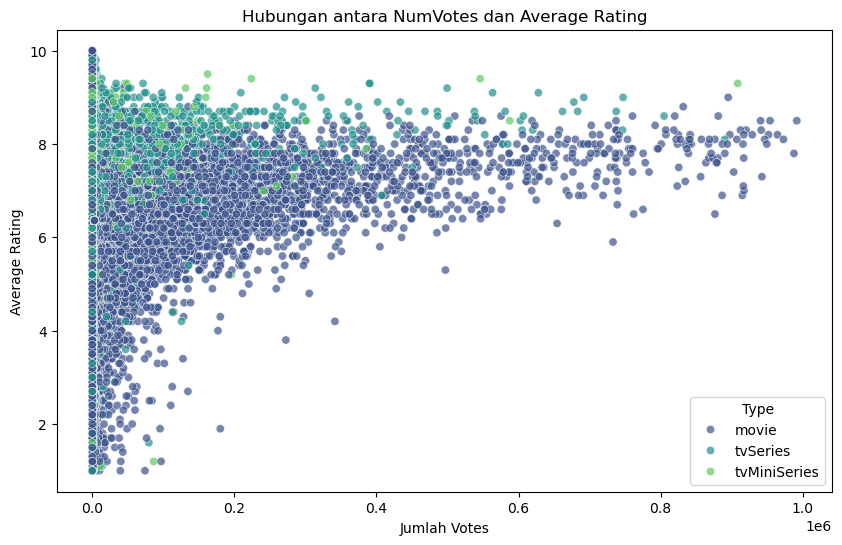

C:\Users\USER\AppData\Local\Temp\ipykernel_15856\3587152698.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_genres.index, y=top_genres.values, palette='coolwarm')


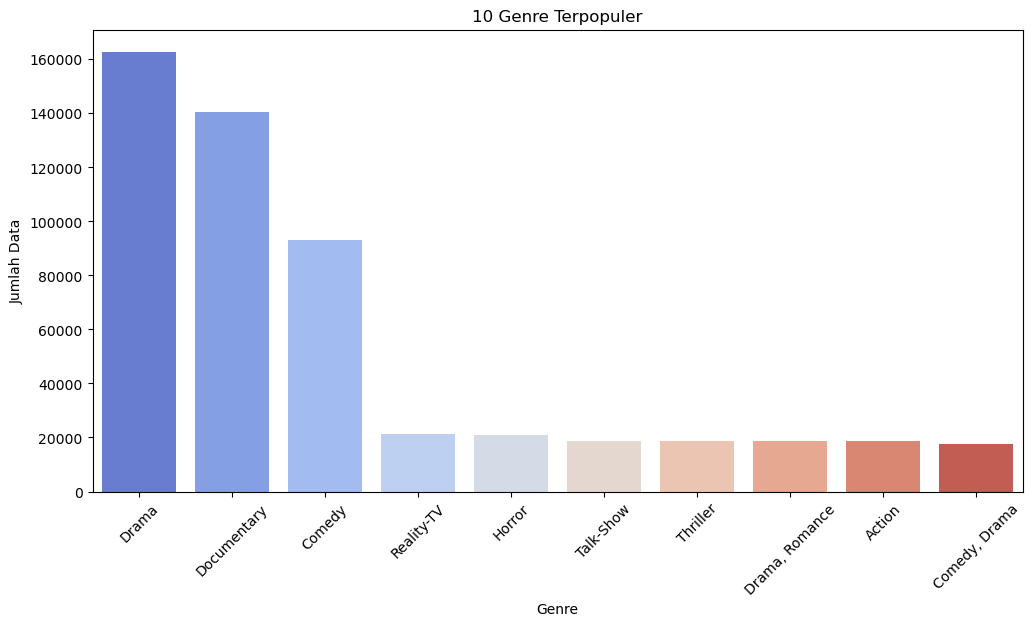

C:\Users\USER\AppData\Local\Temp\ipykernel_15856\3587152698.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='type', y='averageRating', palette='Set2')


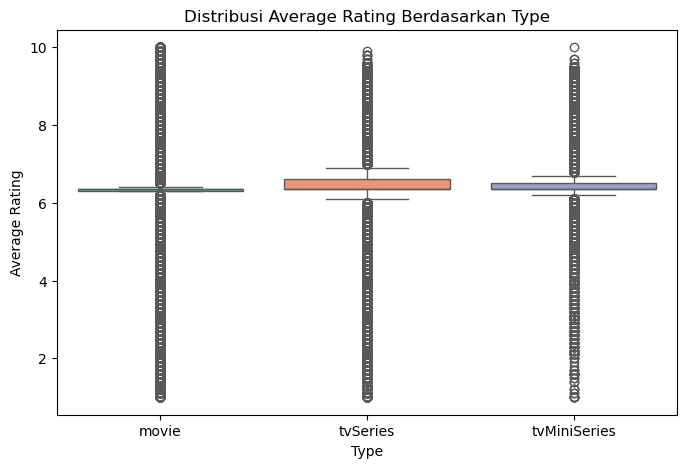

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Membaca dataset yang telah dibersihkan
df = pd.read_csv('data_cleaned.csv')

# 1. Visualisasi Distribusi 'averageRating'
plt.figure(figsize=(8, 5))
sns.histplot(df['averageRating'], bins=20, kde=True, color='skyblue')
plt.title('Distribusi Average Rating')
plt.xlabel('Average Rating')
plt.ylabel('Frekuensi')
plt.show()

# 2. Scatter Plot: Hubungan antara 'numVotes' dan 'averageRating'
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='numVotes', y='averageRating', hue='type', palette='viridis', alpha=0.7)
plt.title('Hubungan antara NumVotes dan Average Rating')
plt.xlabel('Jumlah Votes')
plt.ylabel('Average Rating')
plt.legend(title='Type')
plt.show()

# 3. Bar Chart: 10 Genre Terpopuler
plt.figure(figsize=(12, 6))
top_genres = df['genres'].value_counts().head(10)
sns.barplot(x=top_genres.index, y=top_genres.values, palette='coolwarm')
plt.title('10 Genre Terpopuler')
plt.xlabel('Genre')
plt.ylabel('Jumlah Data')
plt.xticks(rotation=45)
plt.show()

# 4. Boxplot: Distribusi 'averageRating' berdasarkan 'type'
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='type', y='averageRating', palette='Set2')
plt.title('Distribusi Average Rating Berdasarkan Type')
plt.xlabel('Type')
plt.ylabel('Average Rating')
plt.show()
